In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'full_df.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values
cleaned_data = data.dropna()


In [2]:
cleaned_data

,Unnamed: 0,year,month,lon_rounded_up,lat_rounded_up,chlor_a,sst,elevation,salinity,oxygen
31,31,2004,4,-80,-5,1.337677,29.304402,-3630.6202,34.956667,159.333333
32,32,2004,4,-80,0,0.679628,29.925723,-2036.1920,34.998571,216.142857
41,41,2004,4,-75,-5,4.035581,29.253682,1272.5898,34.950000,126.000000
67,67,2004,4,-65,25,0.034779,24.070602,-5404.0020,36.725785,203.064534
77,77,2004,4,-60,25,0.028865,24.238852,-5720.3907,36.751445,201.737188
...,...,...,...,...,...,...,...,...,...,...
47981,47981,2024,3,-5,-5,0.080399,30.646370,-4169.1514,35.635402,137.879139
47982,47982,2024,3,-5,0,0.169007,30.156470,-4439.8755,35.426486,123.729677
47991,47991,2024,3,0,-5,0.103212,30.713770,-4567.3715,35.449741,115.647645
47992,47992,2024,3,0,0,0.190238,29.917971,-4771.7100,35.457033,110.844104


In [8]:

# Feature variables and target variable (oxygen)
X = cleaned_data[['chlor_a', 'sst', 'salinity', 'elevation']]
y = cleaned_data['oxygen']

In [9]:
y

31       159.333333
32       216.142857
41       126.000000
67       203.064534
77       201.737188
            ...    
47981    137.879139
47982    123.729677
47991    115.647645
47992    110.844104
47993    123.202695
Name: oxygen, Length: 4854, dtype: float64

RMSE: 29.047868939751023


/home/th582/miniforge3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


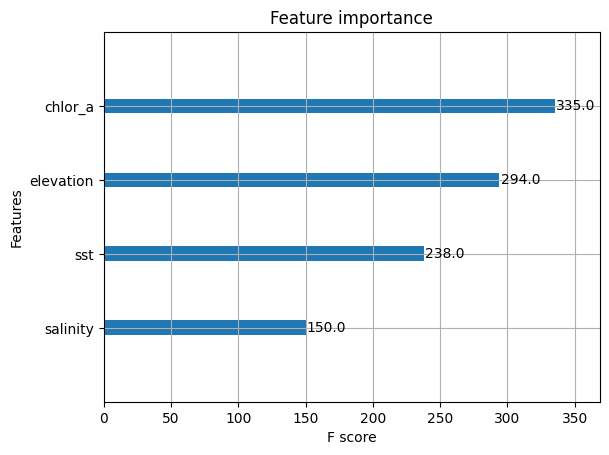

In [10]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=50)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

#calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Feature importance plot
xgb.plot_importance(xg_reg)
plt.show()



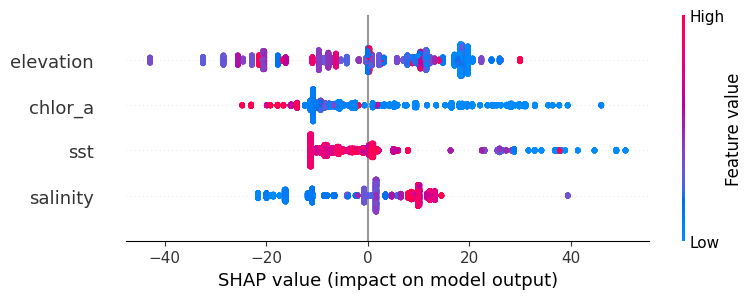

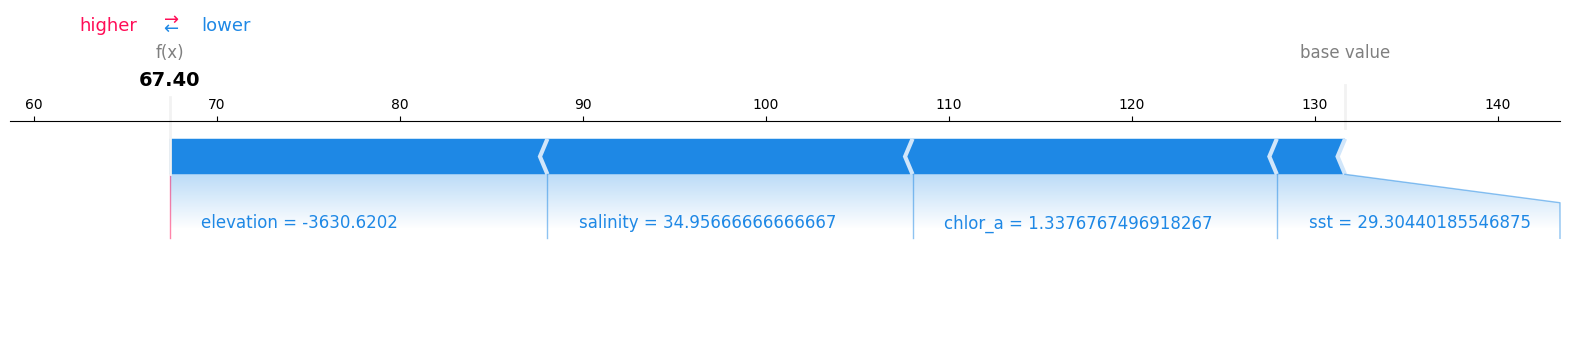

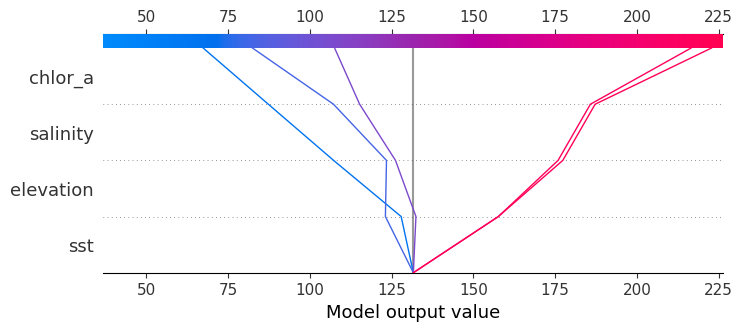

In [11]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xg_reg)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Global Interpretability: SHAP summary plot
shap.summary_plot(shap_values, X)

# Local Interpretability: SHAP force plot for the first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

# Local Interpretability: SHAP decision plot for the first few predictions
shap.decision_plot(explainer.expected_value, shap_values[:5,:], X.iloc[:5,:])

# SHAP interaction values (Optional)
# shap_interaction_values = explainer.shap_interaction_values(X)
# shap.summary_plot(shap_interaction_values, X)


In [12]:

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.3, 0.7]

}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rmse = (-grid_search.best_score_)**0.5

print(f'Best Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best RMSE: 33.0385368935293
